In [1]:
# Import packages
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose 
import seaborn as sns

In [2]:
df = pd.read_csv("Electric_Production.csv")
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [3]:
df.shape

(397, 2)

In [4]:
df.columns = ['Date' , 'EP']
df.head()

,Date,EP
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [5]:
# Convert column year in datetime format
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [6]:
df.head()

,EP
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'EP')

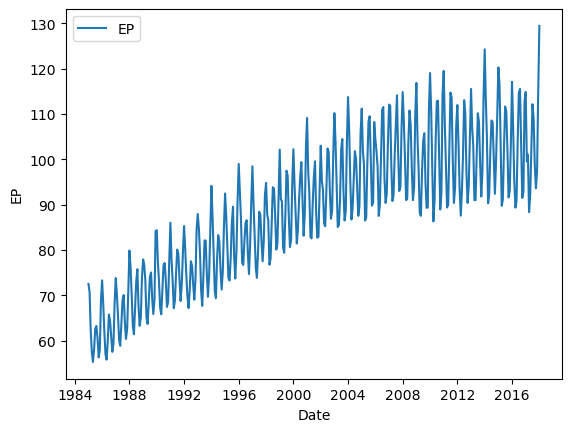

In [7]:
sns.lineplot(df)
plt.ylabel("EP")

<Axes: xlabel='Date'>

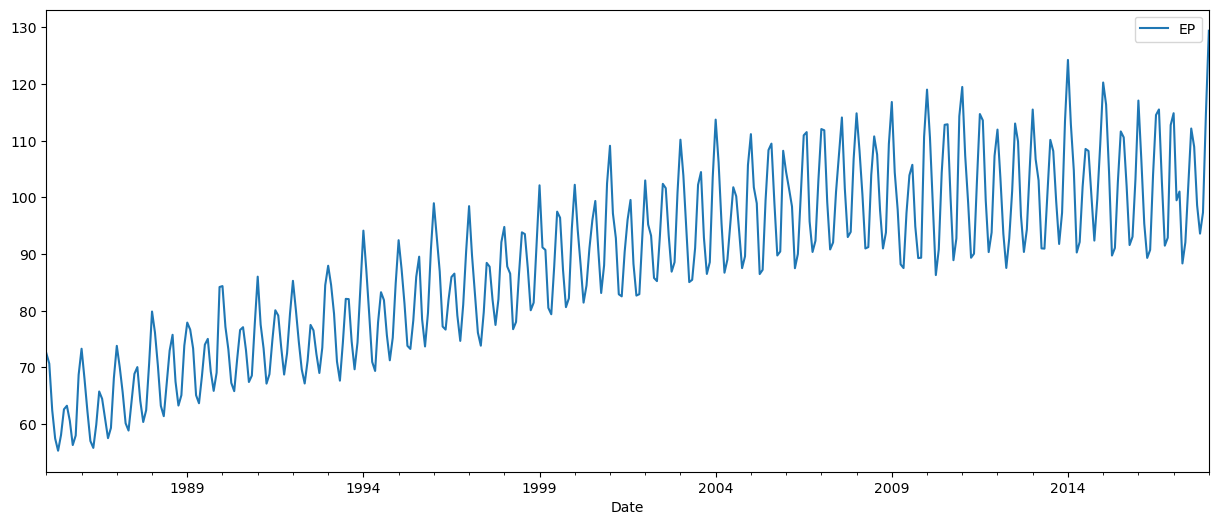

In [8]:
df.plot(figsize=(15,6))


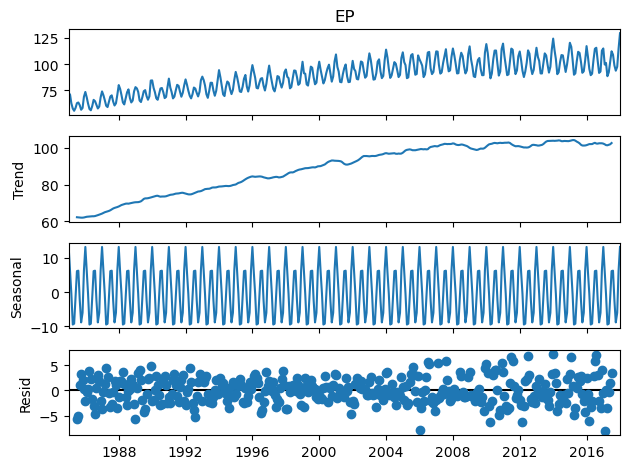

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(df['EP'],model='additive',period=12)
result.plot()
plt.show()

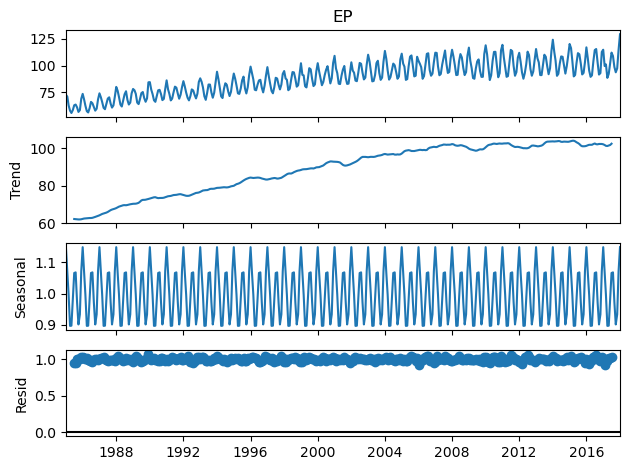

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(df['EP'],model='multiplicative',period=12)
result.plot()
plt.show()

In [11]:
import pymannkendall as mk

# Perform Mann-Kendall test
# H0: There is no monotonic trend in the series

mk.original_test(df['EP'])

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=19.125339232804578, Tau=0.6427499173091112, s=50524.0, var_s=6978466.0, slope=0.11486610139860137, intercept=67.03601192307693)

In [12]:
train_df=df[:int(df.shape[0]*0.7)]
test_df=df[int(df.shape[0]*0.7):]


In [13]:
train_df.shape

(277, 1)

In [14]:
from statsmodels.tsa.api import ExponentialSmoothing , SimpleExpSmoothing , Holt

fitted_model = ExponentialSmoothing(train_df['EP'],trend='add',seasonal='add',seasonal_periods=12).fit()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [15]:
fitted_model.params

{'smoothing_level': 0.39353257738362746,
 'smoothing_trend': 0.0,
 'smoothing_seasonal': 0.26011863530030677,
 'damping_trend': nan,
 'initial_level': 62.43279730454734,
 'initial_trend': 0.144956818052901,
 'initial_seasons': array([10.27486804,  6.42520513,  0.35967342, -5.34731735, -6.63722442,
        -2.37084929,  2.5454322 ,  2.43636259, -2.31114285, -6.18830092,
        -4.08324674,  5.43597514]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [16]:
residuals = fitted_model.resid
residuals.head()

Date
1985-01-01   -0.347422
1985-02-01    1.660806
1985-03-01   -1.294000
1985-04-01   -0.201535
1985-05-01   -1.133574
dtype: float64

In [17]:
test_predictions = fitted_model.forecast(len(test_df)).rename('HW Test Forecast')

In [18]:
test_predictions.tail()

2017-09-01    116.297379
2017-10-01    109.190245
2017-11-01    111.197022
2017-12-01    125.175611
2018-01-01    131.934824
Freq: MS, Name: HW Test Forecast, dtype: float64

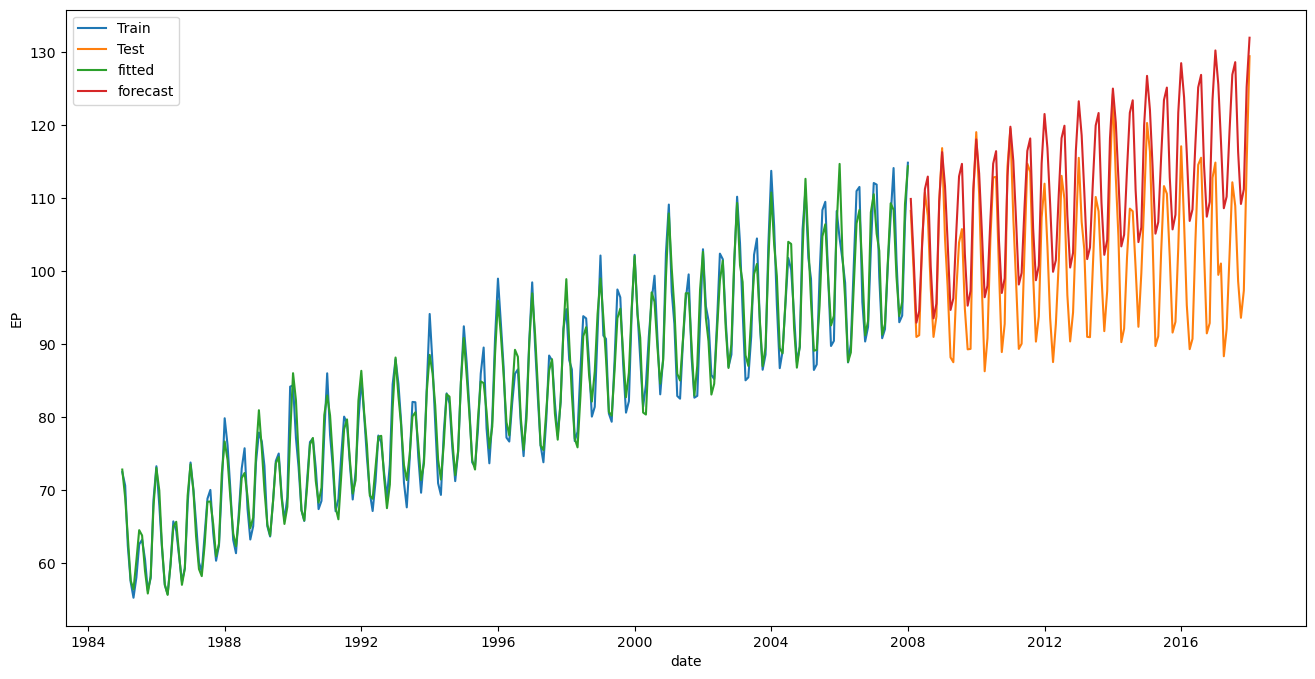

In [19]:
plt.figure(figsize=(16,8))
plt.plot(train_df['EP'],label='Train')
plt.plot(test_df['EP'], label = 'Test')
plt.plot(fitted_model.fittedvalues , label='fitted')
plt.plot(test_predictions , label ='forecast')
plt.xlabel('date')
plt.ylabel('EP')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
mape_test = mean_absolute_percentage_error(test_df['EP'],test_predictions)
print('MAPE for Test Data:', mape_test)

MAPE for Test Data: 0.09448179758628884


In [21]:
from statsmodels.tsa.stattools import adfuller
print("Results of Dickey-Fuller Test:")
dftest = adfuller(df['EP'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.256990
p-value                          0.186215
#Lags Used                      15.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


In [22]:
from statsmodels.tsa.stattools import kpss
kp = kpss(df['EP'])
p = kp[1]

print("p-value for KPSS test (untransformed) = ", p)


p-value for KPSS test (untransformed) =  0.01


C:\Users\Tanvi.Koyande\AppData\Local\Temp\ipykernel_10368\697619094.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kp = kpss(df['EP'])


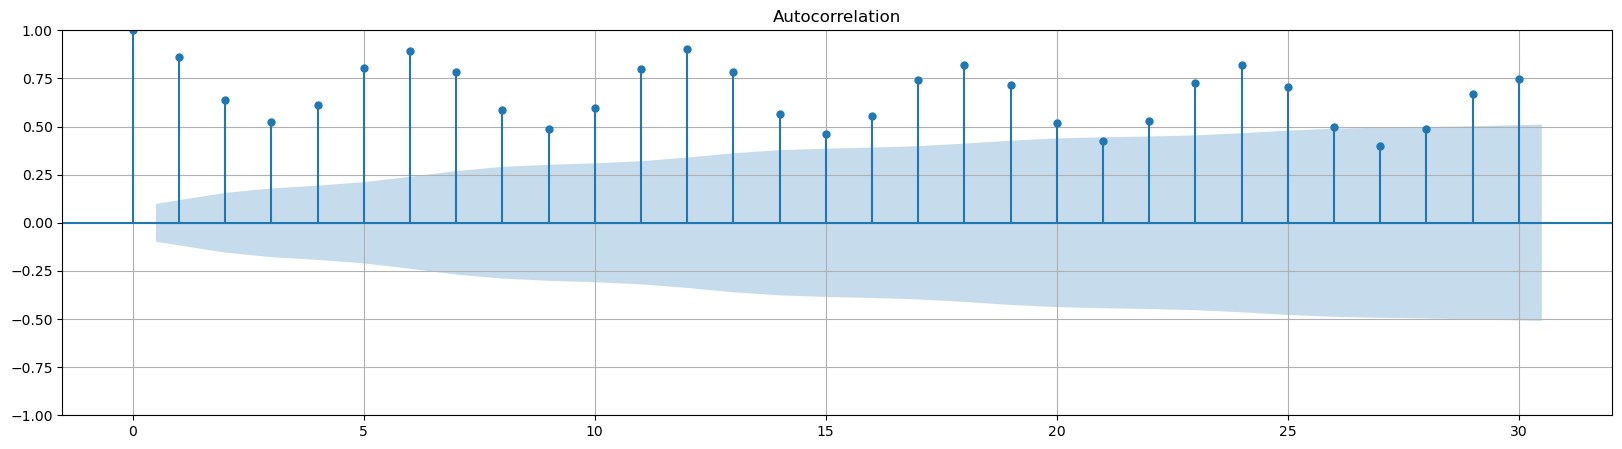

In [23]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(20, 5))
plt.grid()
plot_acf(df['EP'] , ax=plt.gca(), lags =30 )
plt.show()

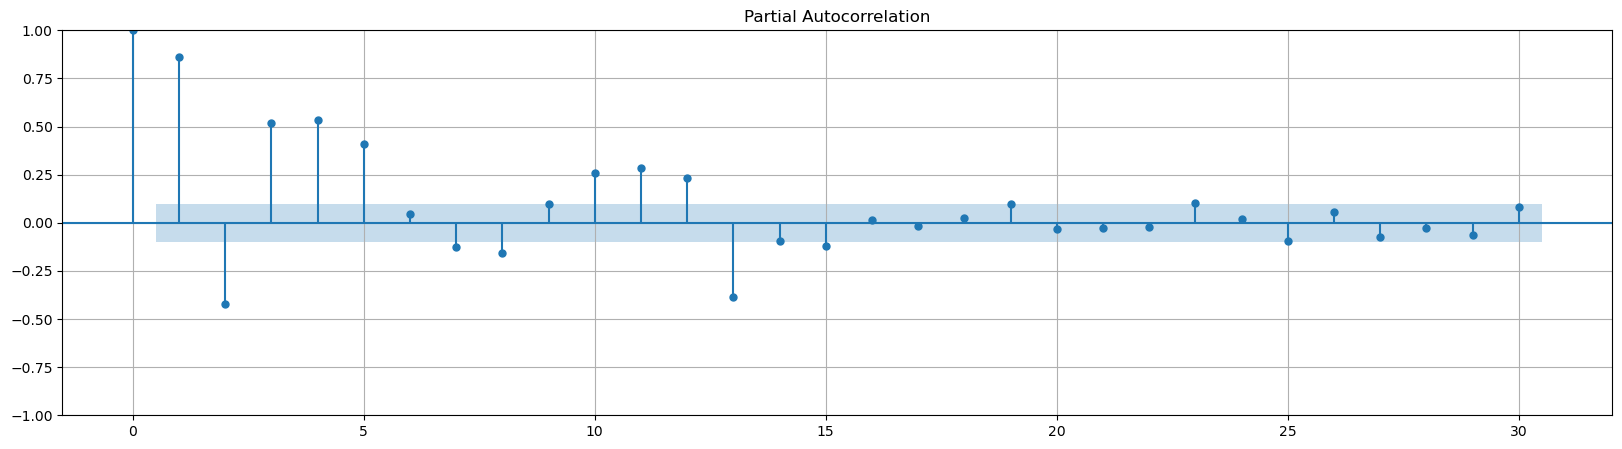

In [24]:
plt.figure(figsize=(20, 5))
plt.grid()
plot_pacf(df['EP'] , ax=plt.gca(), lags = 30)
plt.show()

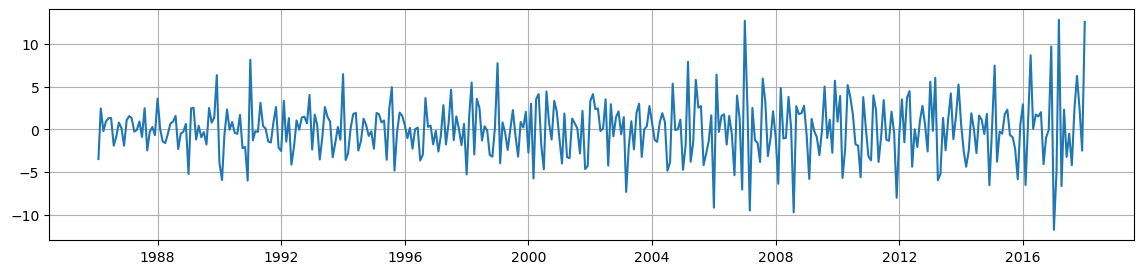

In [25]:
sdiff = df['EP'].diff(periods = 12).dropna()  # seasonal differencing
sddiff = sdiff.diff().dropna()                          # non-seasonal differencing  # 1ST ORDER DIFFERENCING
plt.figure(figsize=(14, 3))
plt.grid()
plt.plot(sddiff)

plt.show()

In [26]:
print("Results of Dickey-Fuller Test:")
dftest = adfuller(sddiff)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -8.022039e+00
p-value                        2.063925e-12
#Lags Used                     1.500000e+01
Number of Observations Used    3.680000e+02
Critical Value (1%)           -3.448245e+00
Critical Value (5%)           -2.869426e+00
Critical Value (10%)          -2.570971e+00
dtype: float64


In [27]:
#KPSS
from statsmodels.tsa.stattools import kpss
kp = kpss(sddiff)
p = kp[1]

print("p-value for KPSS test (untransformed) = ", p)

p-value for KPSS test (untransformed) =  0.1


C:\Users\Tanvi.Koyande\AppData\Local\Temp\ipykernel_10368\3820050715.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kp = kpss(sddiff)


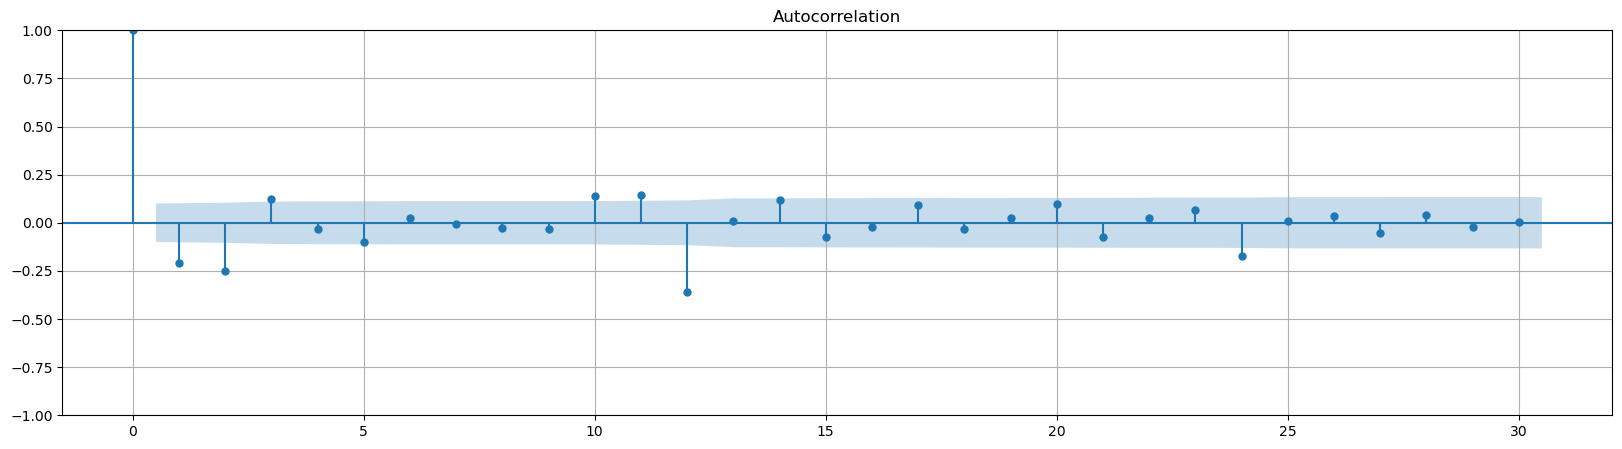

In [28]:
plt.figure(figsize=(20, 5))
plt.grid()
plot_acf(sddiff , ax=plt.gca(), lags = 30)
plt.show()

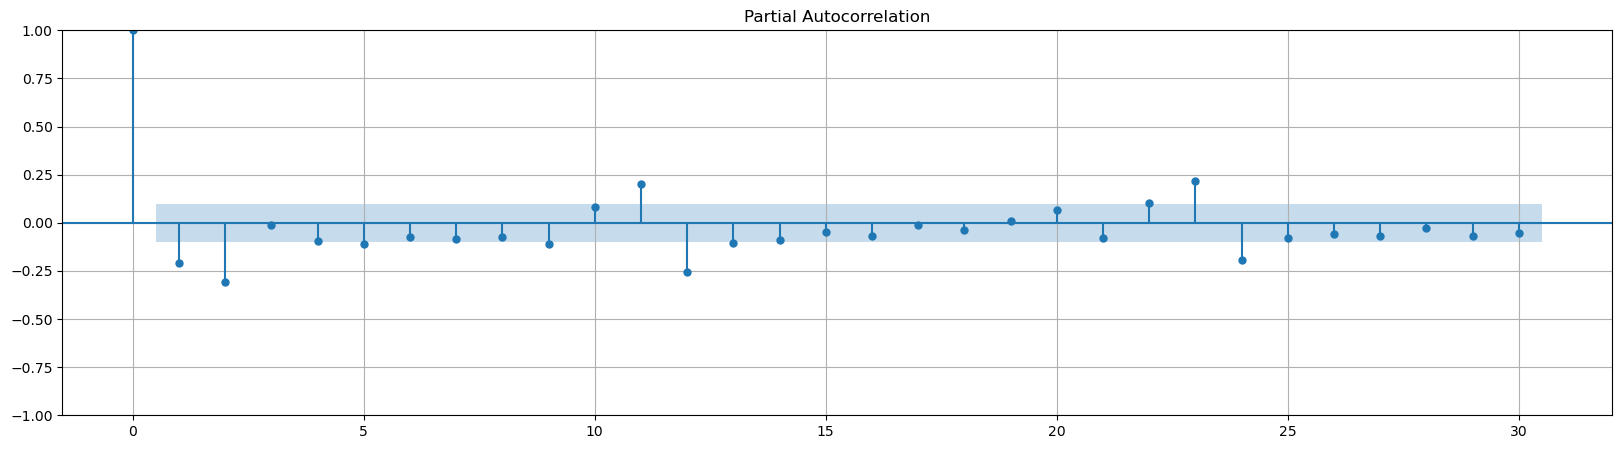

In [29]:
plt.figure(figsize=(20, 5))
plt.grid()
plot_pacf(sddiff , ax=plt.gca(), lags = 30)
plt.show()

In [30]:
from pmdarima.arima import auto_arima
model_auto_arima = auto_arima(df['EP'], seasonal=True, trace = True , m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1953.424, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2750.050, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2401.309, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2748.185, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=1955.636, Time=2.19 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=2.25 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2105.437, Time=0.49 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=2016.179, Time=1.82 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=inf, Time=2.09 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=3.74 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=1866.763, Time=1.10 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=2265.6

In [31]:
import statsmodels.api as sm
model_2 = sm.tsa.statespace.SARIMAX(train_df['EP'], order=(1,1,2), seasonal_order = (1,0,1,12))
model_2_fit = model_2.fit()

print(model_2_fit.summary())

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                      SARIMAX Results                                       
Dep. Variable:                                   EP   No. Observations:                  277
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -612.292
Date:                              Thu, 23 Jan 2025   AIC                           1236.583
Time:                                      11:59:48   BIC                           1258.306
Sample:                                  01-01-1985   HQIC                          1245.300
                                       - 01-01-2008                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3050      0.132      2.320      0.020       0.047       0.563
ma.L1         -0.73

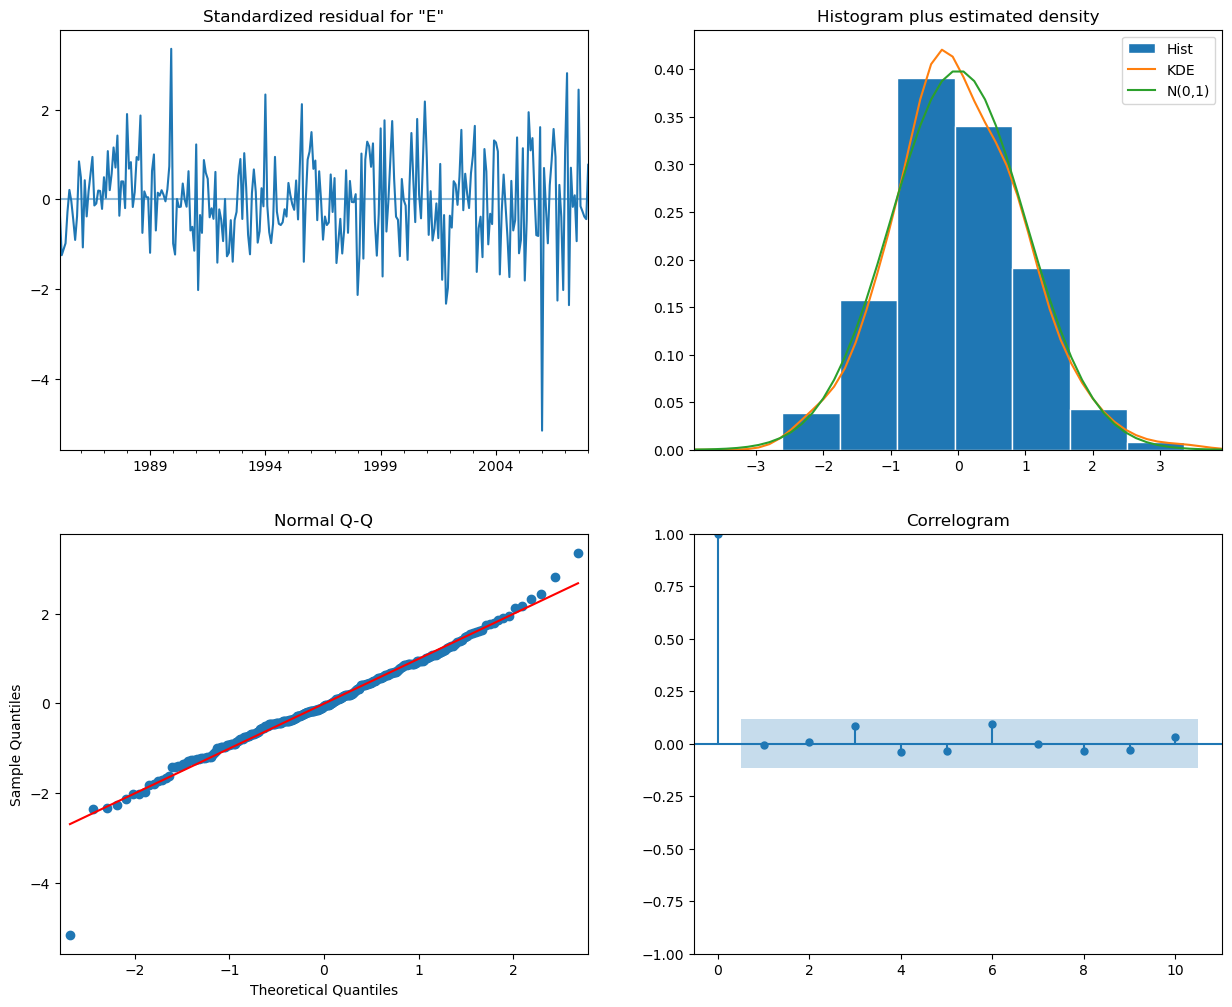

In [32]:
model_2_fit.plot_diagnostics(figsize=(15,12))
plt.show()

In [33]:
test_predictions2 = model_2_fit.forecast(len(test_df))
forecast_further2 = model_2_fit.forecast(len(test_df['EP'])+90)
forecast_further2 = forecast_further2[test_df.index.max():]
forecast_further2

2018-01-01    129.028578
2018-02-01    124.299441
2018-03-01    117.562077
2018-04-01    108.577938
2018-05-01    109.695474
                 ...    
2025-03-01    127.920577
2025-04-01    119.245520
2025-05-01    120.324609
2025-06-01    128.362982
2025-07-01    135.700235
Freq: MS, Name: predicted_mean, Length: 91, dtype: float64

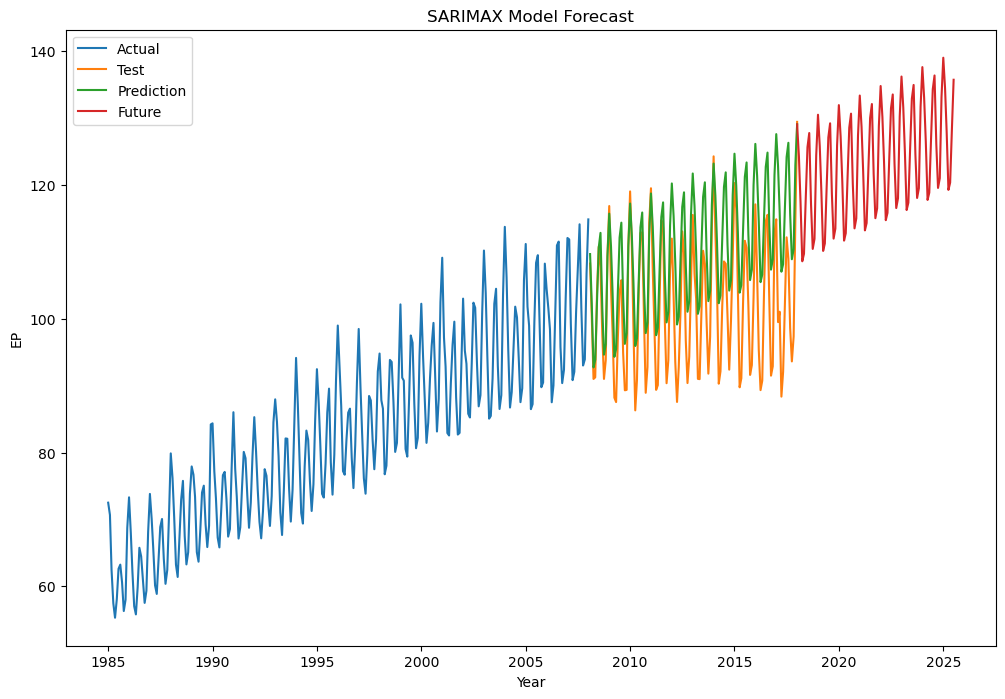

In [35]:
plt.figure(figsize=(12, 8))

plt.plot(train_df['EP'], label='Actual')
plt.plot(test_df['EP'], label='Test')
plt.plot(test_predictions2, label='Prediction')
plt.plot(forecast_further2, label='Future')

plt.title('SARIMAX Model Forecast')
plt.xlabel('Year')
plt.ylabel('EP')
plt.legend()

plt.show()

In [36]:
mape_test_arima2 = mean_absolute_percentage_error(test_df['EP'],test_predictions2)
print('MAPE for TEST Data:', mape_test_arima2)

MAPE for TEST Data: 0.0862379804230265


In [37]:
##INTERPRETATION ON ACF AND PACF

In [39]:
import statsmodels.api as sm
model_1 = sm.tsa.statespace.SARIMAX(train_df['EP'], order=(1,1,1), seasonal_order = (1,1,1,12))
model_1_fit = model_1.fit()

print(model_1_fit.summary())

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                                 EP   No. Observations:                  277
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -575.211
Date:                            Thu, 23 Jan 2025   AIC                           1160.422
Time:                                    12:02:18   BIC                           1178.302
Sample:                                01-01-1985   HQIC                          1167.607
                                     - 01-01-2008                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4861      0.056      8.618      0.000       0.376       0.597
ma.L1         -0.9810      0.019   

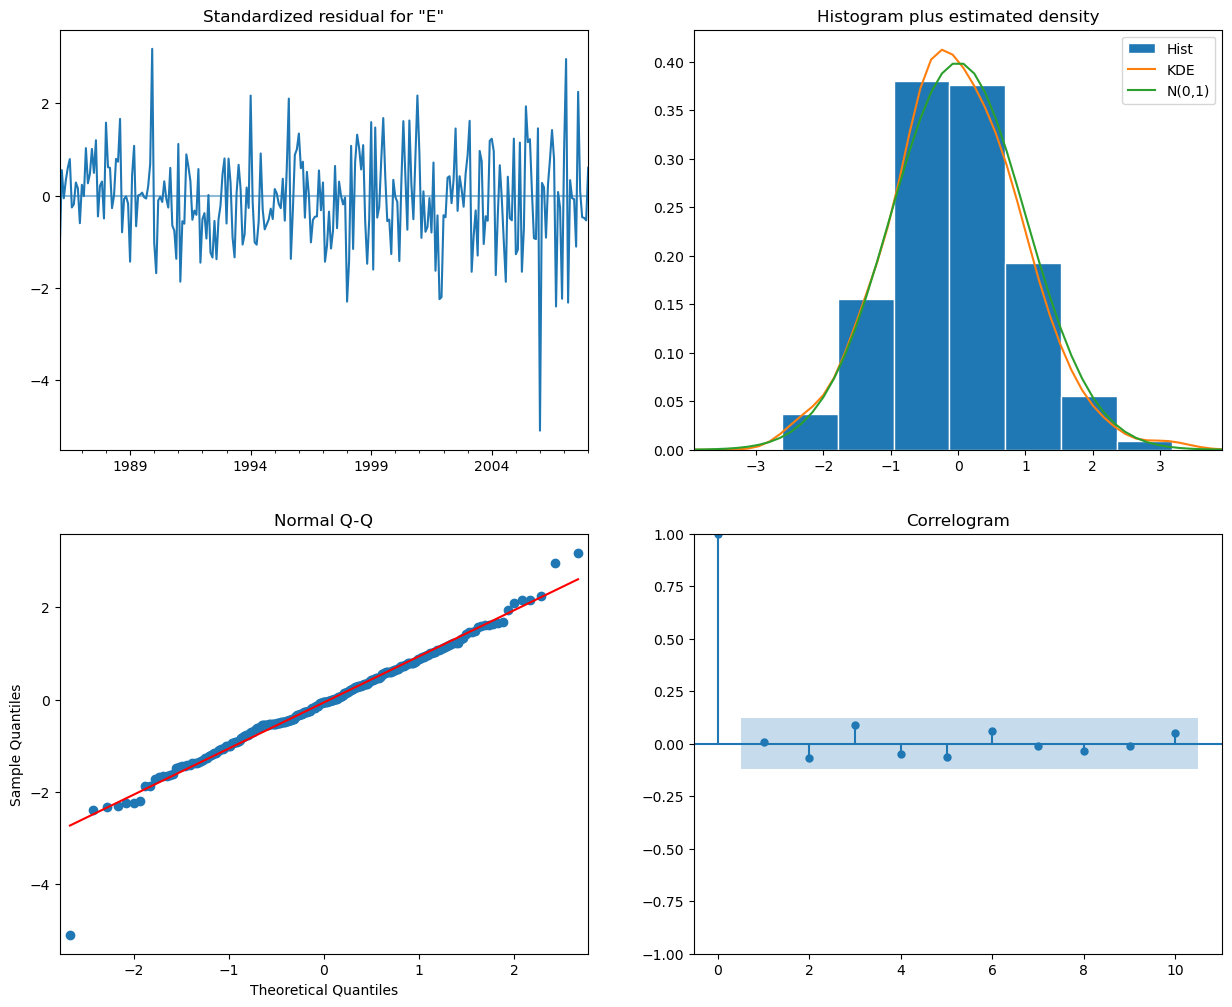

In [40]:
model_1_fit.plot_diagnostics(figsize=(15,12))
plt.show()

In [41]:
test_predictions1 = model_1_fit.forecast(len(test_df))
forecast_further1=model_1_fit.forecast(len(test_df['EP'])+90)
forecast_further1 = forecast_further1[test_df.index.max():]
forecast_further1

2018-01-01    131.233972
2018-02-01    126.187633
2018-03-01    119.036998
2018-04-01    109.462493
2018-05-01    110.648377
                 ...    
2025-03-01    130.734526
2025-04-01    121.160021
2025-05-01    122.345905
2025-06-01    131.234333
2025-07-01    139.346525
Freq: MS, Name: predicted_mean, Length: 91, dtype: float64

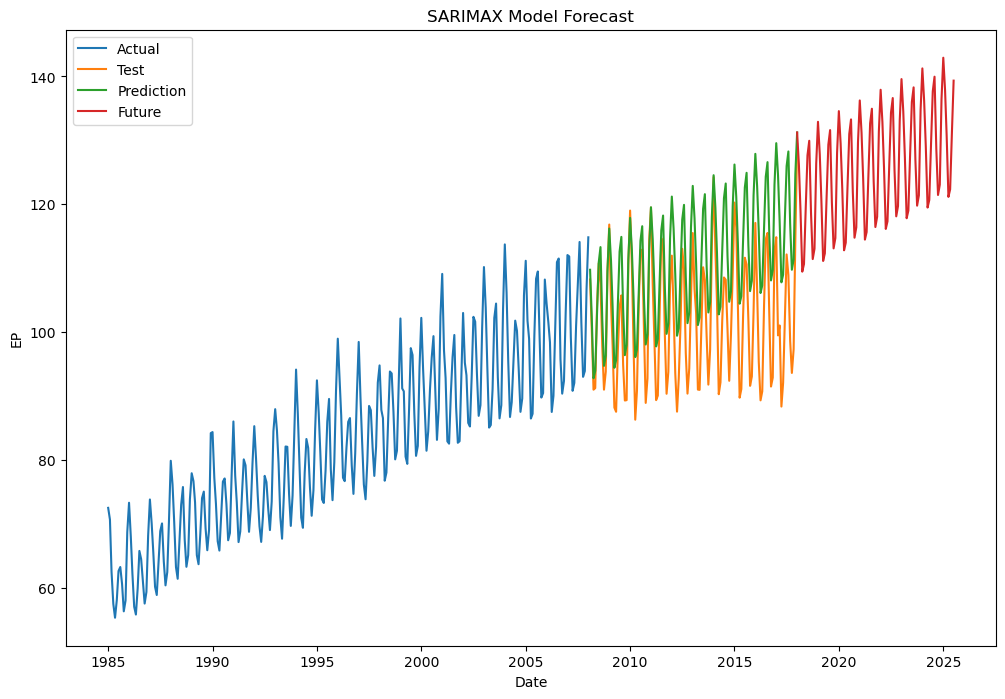

In [42]:
plt.figure(figsize=(12, 8))

plt.plot(train_df['EP'], label='Actual')
plt.plot(test_df['EP'], label='Test')
plt.plot(test_predictions1, label='Prediction')
plt.plot(forecast_further1, label='Future')

plt.title('SARIMAX Model Forecast')
plt.xlabel('Date')
plt.ylabel('EP')
plt.legend()

plt.show()

In [43]:
mape_test1 = mean_absolute_percentage_error(test_df['EP'],test_predictions1)
print('MAPE for TEST Data:', mape_test1)

MAPE for TEST Data: 0.09303131713801367


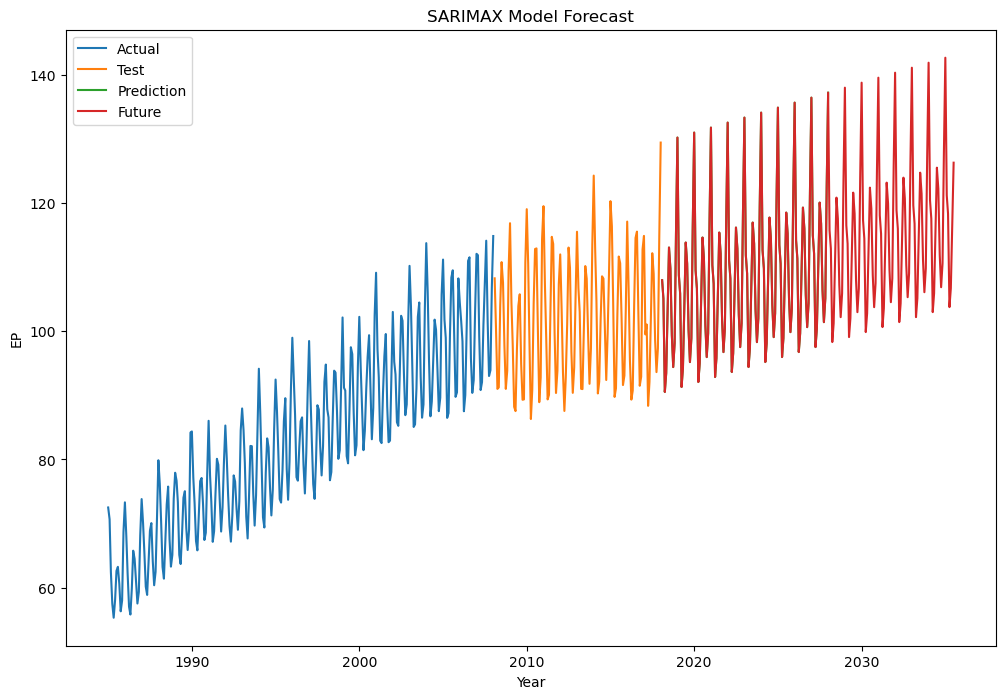

In [53]:
plt.figure(figsize=(12, 8))

plt.plot(train_df['EP'], label='Actual')
plt.plot(test_df['EP'], label='Test')
plt.plot(test_predictions, label='Prediction')
plt.plot(forecast_further, label='Future')


plt.title('SARIMAX Model Forecast')
plt.xlabel('Year')
plt.ylabel('EP')
plt.legend()

plt.show()

In [54]:
from sklearn.metrics import mean_absolute_percentage_error
mape_test = mean_absolute_percentage_error(test_df['EP'],test_predictions)
print('MAPE for TEST Data:', mape_test)

MAPE for TEST Data: 0.06542031080770311


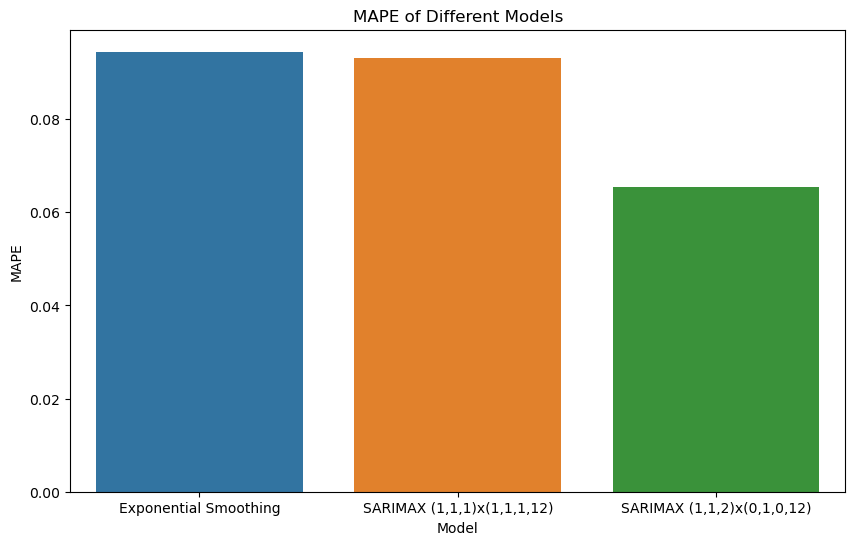

In [55]:
# prompt: plot the mape of all models make a table

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create some data for the table
models = ['Exponential Smoothing', 'SARIMAX (1,1,1)x(1,1,1,12)', 'SARIMAX (1,1,2)x(0,1,0,12)']
mape_test = [0.094481797586288847, 0.09303131713801367, 0.06542031080770311]

# Create the table
table = pd.DataFrame({'Model': models, 'MAPE Test': mape_test})

# Plot the table
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MAPE Test', data=table)
plt.xlabel('Model')
plt.ylabel('MAPE')
plt.title('MAPE of Different Models')
plt.show()